In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import netCDF4 as nc
import scipy.io as sio
from datetime import datetime
from datetime import datetime, timedelta

import sys
sys.path.append("/home/z5297792/UNSW-MRes/MRes/modules")
from utils import dopioe, smooth, robust_smooth, fit_psi_params, psi_params, dopioe_pipeliner
from utils import normalize_matrix, calc_ow, find_directional_radii, axis_ratio


### Numerical Data

In [2]:
ssh_path = '/srv/scratch/z5297792/ESP_Paper_Data/sat_data_copernicus_CCE_2023_1D_3000m.nc'
ssh_dataset = nc.Dataset(ssh_path, mode='r')

z_ssh = ssh_dataset['depth'][:].data
lon_ssh, lat_ssh = ssh_dataset['longitude'][:].data, ssh_dataset['latitude'][:].data
lon_ssh, lat_ssh = np.meshgrid(lon_ssh, lat_ssh, indexing='ij')
u_ssh, v_ssh = ssh_dataset['uo'][:].data, ssh_dataset['vo'][:].data
u_ssh, v_ssh = np.transpose(u_ssh, axes=(3,2,1,0)), np.transpose(v_ssh, axes=(3,2,1,0)) # LON, LAT, DEPTH, TIME
tim_ssh = ssh_dataset['time'][:].data # Hours Since 1950-01-01

ref_date = pd.Timestamp("1950-01-01 00:00:00")
tim_ssh = ref_date + pd.to_timedelta(tim_ssh, unit="h")

dic_ssh_data = {}
for t, time in enumerate(tim_ssh):
    ut, vt = u_ssh[:,:,:,t], v_ssh[:,:,:,t]
    ut = np.where(np.abs(ut) < 100, ut, np.nan)
    vt = np.where(np.abs(vt) < 100, vt, np.nan)
    dic_ssh_data[time] = {'u': ut, 'v': vt}

theta_mean, phi_mean = np.float64(154.3), np.float64(-37.9)
x_ssh = (lon_ssh - theta_mean) * 111000 * np.cos(np.deg2rad(phi_mean))
y_ssh = (lat_ssh - phi_mean) * 111000


In [3]:
df_res = pd.read_pickle("/srv/scratch/z5297792/MRes_thesis_ESP_application_files/df_res_NUM_DOPIOE.pkl")
df_res


,xc,yc,w,Q,Rc,psi0,A,R,Time,Rc_opt,...,sq11,sq12,sq22,sRc,sA,sw,spsi0,e,Data,Method
0,-5800.573587,-629.255116,-4.014495e-11,"[[1.0257835485237767, -0.06582692058402731], [...",79491.032982,59816.106011,-0.000009,51001.244368,2023-10-19 00:00:00,79699.110269,...,0.966217,-0.099441,1.048152,79807.188760,-0.000009,-0.000038,60063.096209,1.113146,Numerical,ESPRA
1,-3945.601076,1292.916423,-3.990317e-11,"[[0.9469093678079432, -0.1025367315065541], [-...",75083.427386,56136.294013,-0.000010,46409.411345,2023-10-19 23:56:15,79631.639879,...,0.948459,-0.103828,1.069215,79846.709559,-0.000009,-0.000038,60208.840554,1.127071,Numerical,ESPRA
2,-7305.893964,-5404.284853,-4.066017e-11,"[[0.9260127534658854, -0.12988710825674335], [...",83502.013651,62281.074330,-0.000009,54731.378198,2023-10-21 00:00:00,80089.626557,...,0.923594,-0.093736,1.098739,79947.422513,-0.000009,-0.000038,60434.171688,1.136040,Numerical,ESPRA
3,-3349.589416,-3906.695508,-4.172008e-11,"[[0.8949996348435911, -0.11703436509009014], [...",75793.781542,57449.638945,-0.000010,46875.124107,2023-10-22 00:00:00,79965.684704,...,0.877455,-0.069186,1.155280,80081.133893,-0.000009,-0.000039,60824.600603,1.166365,Numerical,ESPRA
4,-1579.605006,-4762.774618,-4.163334e-11,"[[0.8243945558653101, -0.05360848246487655], [...",79349.885618,59981.931321,-0.000010,50577.556222,2023-10-22 23:56:15,80349.815211,...,0.852952,-0.021639,1.188928,79998.341004,-0.000010,-0.000039,61161.081784,1.182286,Numerical,ESPRA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
111,-279779.683892,209074.573196,-2.005588e-11,"[[0.7885996834115695, 0.2259406021541657], [0....",63627.454346,30541.381307,-0.000008,39476.018079,2024-02-07 00:00:00,105642.004131,...,1.080474,-0.186402,1.054048,91565.216075,-0.000005,-0.000023,44571.435065,1.193530,Numerical,ESPRA
112,-294028.516283,206607.000527,-2.185470e-11,"[[0.8663067796618311, -0.0737445671419225], [-...",63233.248429,23617.730349,-0.000006,26877.002011,2024-02-08 00:00:00,98540.944435,...,1.016801,-0.147841,1.081765,94053.506719,-0.000005,-0.000023,48384.599033,1.156353,Numerical,ESPRA
113,-294897.807794,204797.106151,-2.347104e-11,"[[1.231391617712457, -0.2514477332016931], [-0...",58290.067512,26067.577198,-0.000008,33198.421948,2024-02-08 23:56:15,92989.327895,...,1.005622,-0.073625,1.052222,98067.599245,-0.000006,-0.000023,53359.161150,1.078094,Numerical,ESPRA
114,-304190.887259,204267.206702,-2.486505e-11,"[[1.100179831548671, -0.164533536757368], [-0....",54752.056555,21736.956008,-0.000007,39119.783170,2024-02-10 00:00:00,90080.711017,...,1.059841,-0.148274,0.981980,96187.098848,-0.000006,-0.000023,52330.572970,1.163350,Numerical,ESPRA


(np.float64(-321623.5831309567),
 np.float64(12430.993298843001),
 np.float64(-17493.371033004067),
 np.float64(219551.48062956132))

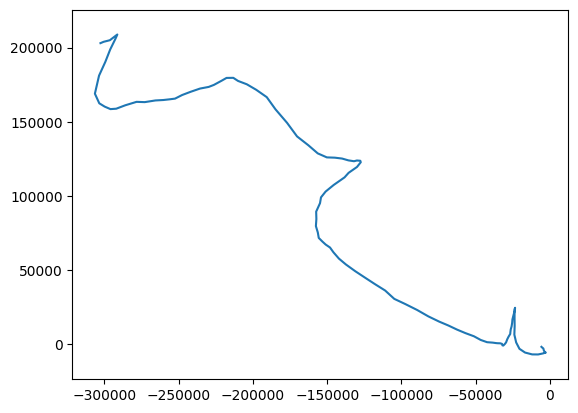

In [4]:
plt.plot(df_res.sxc, df_res.syc)
plt.axis('equal')


In [5]:
dic_k = {}
flag = False
for surf in df_res.itertuples(index=False):
    if flag:
        break
        
    ut, vt = dic_ssh_data[surf.Time]['u'], dic_ssh_data[surf.Time]['v']

    xc_pre, yc_pre = float(surf.sxc), float(surf.syc)
    rows = [{
        'xc': surf.sxc, 'yc': surf.syc, 'w': surf.sw,
        'q11': surf.sq11, 'q12': surf.sq12, 'q22': surf.sq22,
        'Rc': surf.sRc, 'psi0': surf.spsi0, 'A': surf.sA, 'R': surf.R, 'Depth': z_ssh[0]
    }]

    for k in range(1, 34):
        utk, vtk = ut[:, :, k], vt[:, :, k]
    
        xc, yc, w, Q, Rc, psi0, A, R, df = dopioe_pipeliner(xc_pre, yc_pre, 'CE', utk, vtk, x_ssh, y_ssh, r=50000)
    
        if (np.hypot(xc - xc_pre, yc - yc_pre) < 20000.0) and (np.sign(w) < 0):
            q11, q12, q22 = Q[0,0], Q[0,1], Q[1,1]
            rows.append(dict(xc=xc, yc=yc, w=w, q11=q11, q12=q12, q22=q22, Rc=Rc, psi0=psi0, A=A, R=R, Depth=z_ssh[k]))
            xc_pre, yc_pre = xc, yc
        else:
            flag = True
            break  
    
    df_res_k  = pd.DataFrame(rows, columns=['xc','yc','w','q11','q12','q22','Rc','psi0','A','R','Depth'])

    if len(df_res_k) <= 2:
        flag = True
        break 

    wdw = 5
    df_res_k['sq11'] = smooth(df_res_k.q11,  df_res_k.Depth, window=wdw, num=len(df_res_k))
    df_res_k['sq12'] = smooth(df_res_k.q12,  df_res_k.Depth, window=wdw, num=len(df_res_k))
    df_res_k['sq22'] = smooth(df_res_k.q22,  df_res_k.Depth, window=wdw, num=len(df_res_k))
    df_res_k['sRc']  = smooth(df_res_k.Rc,   df_res_k.Depth, window=wdw, num=len(df_res_k))
    df_res_k['spsi0']= smooth(df_res_k.psi0, df_res_k.Depth, window=wdw, num=len(df_res_k))
    df_res_k['sA']   = smooth(df_res_k.A,    df_res_k.Depth, window=wdw, num=len(df_res_k))

    # acting up
    df_res_k['sw']   = 2*df_res_k.sA*(df_res_k.sq11 + df_res_k.sq22)
    
    df_res_k['e'] = axis_ratio(df_res_k)
    dic_k[surf.Time] = df_res_k
    

In [6]:
# rho_core_thresh = 30000.0
# dic_k = {}

# for surf in df_res.itertuples(index=False):
#     ut, vt = dic_ssh_data[surf.Time]['u'], dic_ssh_data[surf.Time]['v']

#     xc_pre, yc_pre = float(surf.sxc), float(surf.syc)
#     q11_pre, q12_pre, q22_pre = float(surf.sq11), float(surf.sq12), float(surf.sq22)

#     rows = [{
#         'xc': surf.sxc, 'yc': surf.syc, 'w': surf.sw,
#         'q11': surf.sq11, 'q12': surf.sq12, 'q22': surf.sq22,
#         'Rc': surf.sRc, 'psi0': surf.spsi0, 'A': surf.sA,
#         'r2_1': surf.r2_1, 'r2_2': surf.r2_2, 'Depth': z_ssh[0]
#     }]

#     for k in range(1, 34):
#         utk, vtk = ut[:, :, k], vt[:, :, k]

#         dxp, dyp = x_ssh - xc_pre, y_ssh - yc_pre
#         rho2_prev = q11_pre*dxp**2 + 2*q12_pre*dxp*dyp + q22_pre*dyp**2
#         mask_core = (rho2_prev >= 0.0) & (np.sqrt(rho2_prev) < rho_core_thresh)
#         if not np.any(mask_core):
#             break

#         xi, yi = x_ssh[mask_core], y_ssh[mask_core]
#         ui, vi = utk[mask_core], vtk[mask_core]

#         xc, yc, w, Q, Rc0, psi00, A0, r2_1, r2_2 = espra(xi, yi, ui, vi, Rc_max=150000, r2_flag=True)

#         q11, q12, q22 = Q[0,0], Q[0,1], Q[1,1]

#         radii = find_directional_radii(utk, vtk, x_ssh, y_ssh, xc, yc, Q)
#         R = float(np.mean([radii['up'], radii['right'], radii['down'], radii['left']]))

#         dxc, dyc = x_ssh - xc, y_ssh - yc
#         rho2_curr = q11*dxc**2 + 2*q12*dxc*dyc + q22*dyc**2
#         rho_outer = max(min(1.75*R, 200000.0), rho_core_thresh)
#         mask_outer = (rho2_curr >= 0.0) & (np.sqrt(rho2_curr) < rho_outer)

#         if (np.hypot(xc - xc_pre, yc - yc_pre) < 100000.0) and (w < 0.0) and (A0 < 0.0):
#             try:
#                 axi, ayi, aui, avi = x_ssh[mask_outer], y_ssh[mask_outer], utk[mask_outer], vtk[mask_outer]
#                 df = psi_params(xc, yc, Q, axi, ayi, aui, avi)
#                 df = df[df.vt <= 0.0]
#                 Rc, psi0, A, r2_2 = fit_psi_params(df.rho2, df.Qr, df.vt, A0=A0, Rc_max=200000, r2_flag=True)
#                 if (not np.isfinite(A)) or (A >= 0.0):
#                     Rc, psi0, A, r2_2 = np.nan, np.nan, A0, np.nan
#             except Exception:
#                 Rc, psi0, A, r2_2 = np.nan, np.nan, A0, np.nan

#             rows.append({'xc': xc, 'yc': yc, 'w': w, 'q11': q11, 'q12': q12, 'q22': q22,
#                          'Rc': Rc, 'psi0': psi0, 'A': A, 'R': R, 'r2_1': r2_1, 'r2_2': r2_2, 'Depth': z_ssh[k]})
#             xc_pre, yc_pre = xc, yc
#             q11_pre, q12_pre, q22_pre = q11, q12, q22
#         else:
#             break

#     df_res_k = pd.DataFrame(rows, columns=['xc','yc','w','q11','q12','q22','Rc','psi0','A','R','r2_1','r2_2','Depth'])

#     wdw = 5
#     df_res_k['sw']   = smooth(df_res_k.w,    df_res_k.Depth, window=wdw, num=len(df_res_k))
#     df_res_k['sq11'] = smooth(df_res_k.q11,  df_res_k.Depth, window=wdw, num=len(df_res_k))
#     df_res_k['sq12'] = smooth(df_res_k.q12,  df_res_k.Depth, window=wdw, num=len(df_res_k))
#     df_res_k['sq22'] = smooth(df_res_k.q22,  df_res_k.Depth, window=wdw, num=len(df_res_k))
#     df_res_k['sRc']  = smooth(df_res_k.Rc,   df_res_k.Depth, window=wdw, num=len(df_res_k))
#     df_res_k['spsi0']= smooth(df_res_k.psi0, df_res_k.Depth, window=wdw, num=len(df_res_k))
#     df_res_k['sA']   = smooth(df_res_k.A,    df_res_k.Depth, window=wdw, num=len(df_res_k))

#     df_res_k['e'] = axis_ratio(df_res_k)
#     dic_k[surf.Time] = df_res_k


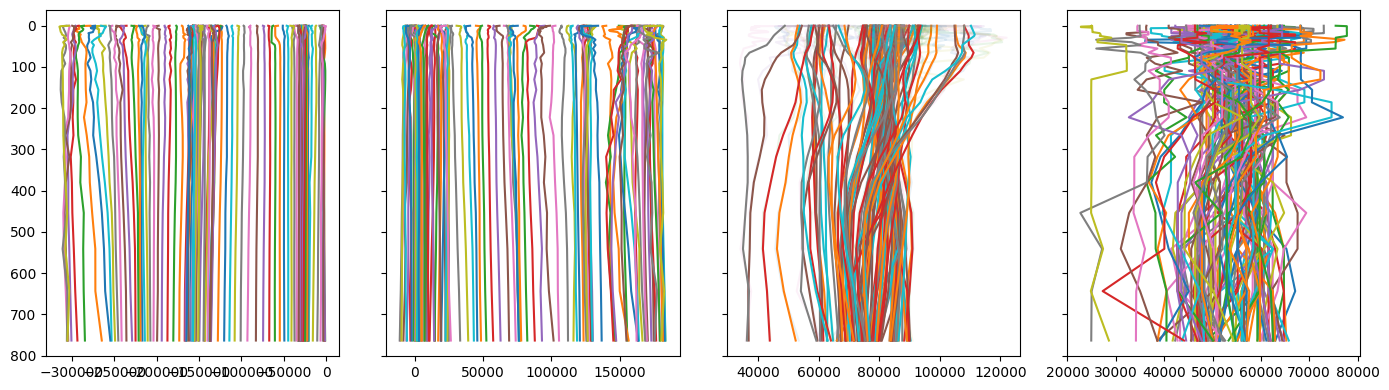

In [7]:
fig, axs = plt.subplots(1, 4, sharey=True, figsize=(14,4))
for t_idx in range(len(dic_k)):
    time = list(dic_k.keys())[t_idx]
    df = dic_k[time]
    axs[0].plot(df.xc, df.Depth)
    axs[1].plot(df.yc, df.Depth)
    axs[2].plot(df.Rc, df.Depth, alpha=.1)
    axs[2].plot(df.sRc, df.Depth)
    axs[3].plot(df.R, df.Depth)
axs[0].invert_yaxis()
plt.tight_layout()
    

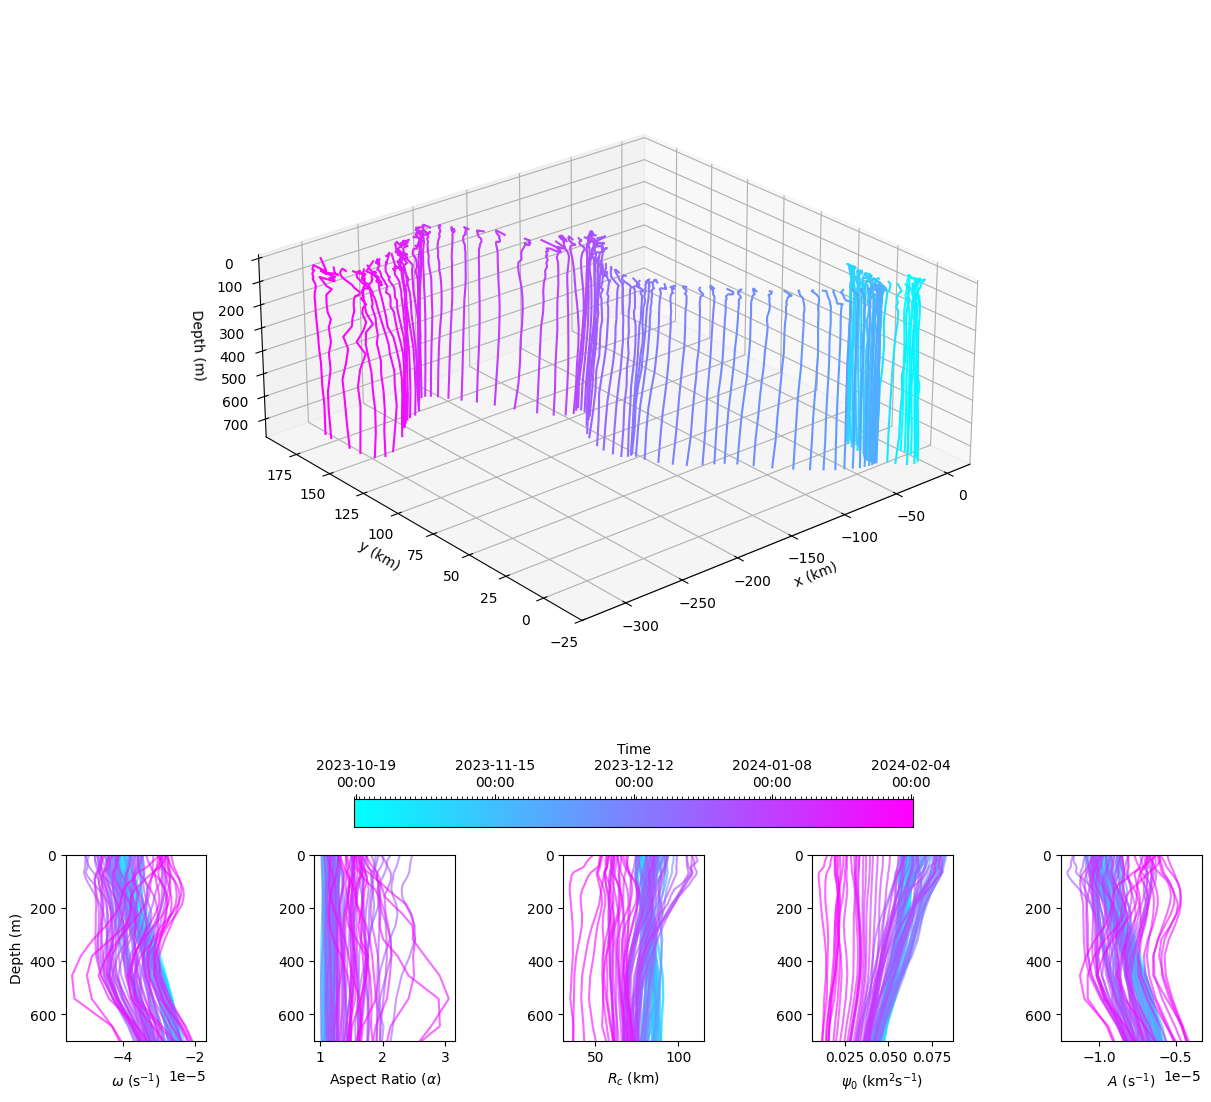

In [8]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib as mpl
import matplotlib.dates as mdates

# === PREP TIME + COLORMAP ===
dt = pd.to_datetime(list(dic_k.keys()), utc=True).tz_localize(None)
dt = pd.to_datetime(sorted(dt))
t = mdates.date2num(dt.to_pydatetime())
n = len(t)

if n > 1:
    mids = (t[:-1] + t[1:]) / 2
    bounds = np.concatenate(([t[0] - (t[1]-t[0])/2], mids, [t[-1] + (t[-1]-t[-2])/2]))
else:
    bounds = np.array([t[0]-0.5, t[0]+0.5])

cmap = mpl.colors.ListedColormap(mpl.cm.cool(np.linspace(0, 1, n)))
norm = mpl.colors.BoundaryNorm(bounds, n)


# === ONE FIGURE, GRID LAYOUT ===
fig = plt.figure(figsize=(12, 12), constrained_layout=True)
gs = fig.add_gridspec(2, 1, height_ratios=[2, 1])  # 2 rows: top=3D, bottom=5 subplots


# === 3D AXIS ON TOP ===
ax3d = fig.add_subplot(gs[0], projection='3d')

for time, df in dic_k.items():
    ti = mdates.date2num(pd.to_datetime(time, utc=True).tz_localize(None).to_pydatetime())
    ax3d.plot(df.xc/1e3, df.yc/1e3, df.Depth, color=cmap(norm(ti)))

ax3d.view_init(elev=25, azim=230)
ax3d.set_xlabel('x (km)')
ax3d.set_ylabel('y (km)')
ax3d.set_zlabel('Depth (m)')
ax3d.invert_zaxis()
# ax3d.set_box_aspect((.1, .1, .03))
ax3d.set_box_aspect((1, 1, 0.4))  # (x, y, z) ratios


# === 2D PARAMETER–DEPTH AXES ON BOTTOM (same colors) ===
axs = []
inner = gs[1].subgridspec(1, 5, wspace=0.3)

names = [("sw", r'$\omega$ (s$^{-1}$)'),
         ("e", r'Aspect Ratio ($\alpha$)'),
         ("sRc", r'$R_c$ (km)'),
         ("spsi0", r'$\psi_0$ (km$^2$s$^{-1}$)'),
         ("sA", r'$A$ (s$^{-1}$)')]

alpha = 0.6

for i, (field, label) in enumerate(names):
    ax = fig.add_subplot(inner[i])
    axs.append(ax)

    for time, df in dic_k.items():
        ti = mdates.date2num(pd.to_datetime(time, utc=True).tz_localize(None).to_pydatetime())
        c = cmap(norm(ti))

        y = df.Depth
        if field == "sRc":
            ax.plot(df[field]/1e3, y, color=c, alpha=alpha)
        elif field == "spsi0":
            ax.plot(df[field]/1e6, y, color=c, alpha=alpha)
        else:
            ax.plot(df[field], y, color=c, alpha=alpha)

    # if field == 'e':
    #     ax.set_xticks([1, 3, 5, 7])
    #     ax.set_xlim(1, None)

    ax.set_xlabel(label)
    ax.invert_yaxis()
    ax.set_ylim(700, 0)

axs[0].set_ylabel("Depth (m)")

sm = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)
sm.set_array(t)

cbar = fig.colorbar(
    sm, ax=axs + [ax3d], location='top', orientation='horizontal',
    boundaries=bounds, spacing='proportional', pad=0.12
)
cbar.set_label("Time")

tick_positions = np.linspace(t.min(), t.max(), 5)
tick_labels = [mdates.num2date(x).strftime('%Y-%m-%d\n%H:%M') for x in tick_positions]

cbar.set_ticks(tick_positions)
cbar.set_ticklabels(tick_labels)  

# plt.tight_layout()
plt.show()


In [9]:
X, Y = x_ssh, y_ssh

U = np.zeros((X.shape[0], X.shape[1], len(z_ssh), len(df_res)))
V = np.zeros((X.shape[0], X.shape[1], len(z_ssh), len(df_res)))
OW = np.zeros((X.shape[0], X.shape[1], len(z_ssh), len(df_res)))

for t_idx in range(len(dic_k)):
    time = list(dic_k.keys())[t_idx]
    df = dic_k[time]

    for k in range(len(df)):
        data = df.iloc[k]
        dx, dy = x_ssh - data.xc, y_ssh - data.yc
        rho2 = data.sq11*dx**2 + 2*data.sq12*dx*dy + data.sq22*dy**2
    
        U[:,:,k,t_idx] = - data.sA * np.exp( - rho2 / data.sRc**2 ) * ( 2*data.sq12*dx + 2*data.sq22*dy )
        V[:,:,k,t_idx] =   data.sA * np.exp( - rho2 / data.sRc**2 ) * ( 2*data.sq11*dx + 2*data.sq12*dy ) 

        OW[:,:,k,t_idx] = calc_ow(U[:,:,k,t_idx].T, V[:,:,k,t_idx].T, X[1,0] - X[0,0], Y[0,1] - Y[0,0]).T
    OW[:,:,:,t_idx] = normalize_matrix(OW[:,:,:,t_idx])


In [10]:
import pickle
df_res_sadcp = pd.read_pickle("/srv/scratch/z5297792/MRes_thesis_ESP_application_files/df_res_SADCP_ESPRA.pkl")


In [11]:
def quad_solver(xc, yc, q11, q12, q22, Rc, y0):

    a = q11
    b = -2*q11*xc + 2*q12*(y0-yc)
    c = q11*xc**2 - 2*q12*xc*(y0-yc) + q22*(y0-yc)**2 - Rc**2/2

    root1 = (-b-np.sqrt(b**2-4*a*c))/(2*a)
    root2 = (-b+np.sqrt(b**2-4*a*c))/(2*a)
    return root1, root2 
    

15.050714211098624
13.054634945489285
12.31891710313099


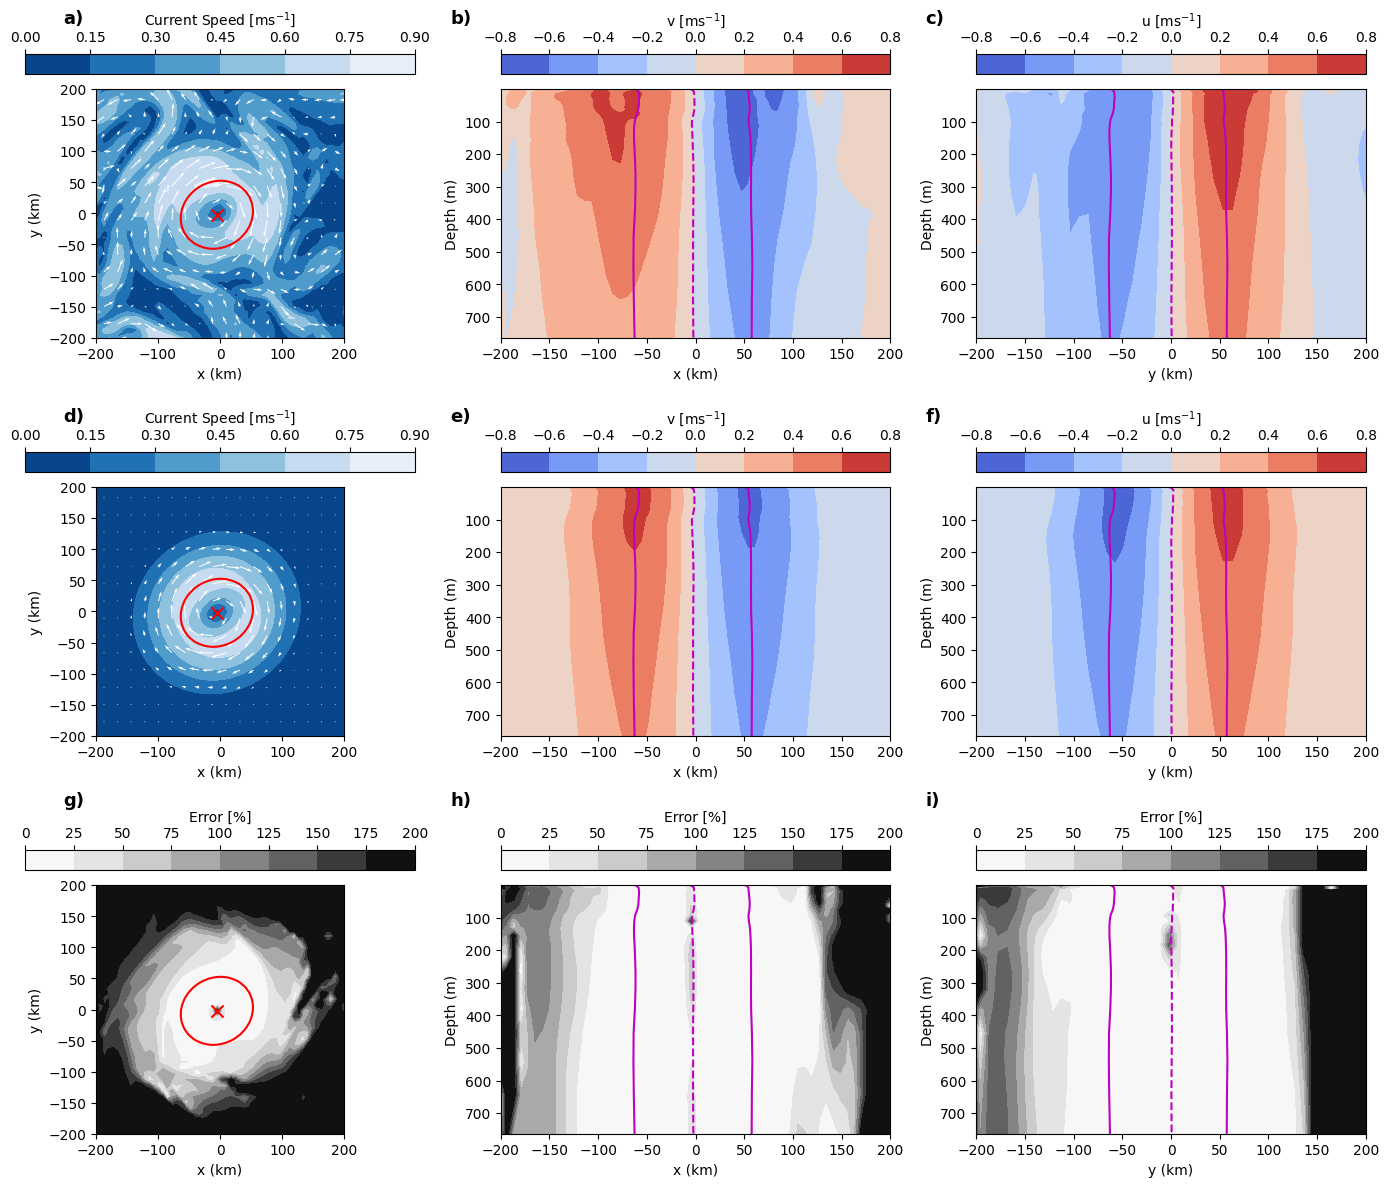

In [13]:
t_sadcp = pd.Timestamp('2023-10-19 18:00:00')
closest = min(df_res.Time, key=lambda tt: abs(tt - t_sadcp))
t_idx = df_res[df_res.Time == closest].index[0]

df_top = dic_k[closest]
surf = df_top.iloc[0]

xc_surf, yc_surf = df_res.loc[t_idx, ['xc','yc']]
ic_surf = np.argmin(np.abs(x_ssh[:,0] - xc_surf))
jc_surf = np.argmin(np.abs(y_ssh[0,:] - yc_surf))
z_lvl_max = 34

u_s, v_s = dic_ssh_data[closest]['u'], dic_ssh_data[closest]['v']

x1d = x_ssh[:,0]/1e3
y1d = y_ssh[0,:]/1e3
xlim = (-200, 200)
ylim = (-200, 200)
ix = (x1d >= xlim[0]-10) & (x1d <= xlim[1]+10)
iy = (y1d >= ylim[0]-10) & (y1d <= ylim[1]+10)
X = (x_ssh[ix][:,iy])/1e3
Y = (y_ssh[ix][:,iy])/1e3

fig, axs = plt.subplots(3, 3, figsize=(14,12))
labels = ['a)','b)','c)','d)','e)','f)']

spac = 3

# --- Top row (SSH-derived) ---
ax = axs[0,0]
S0 = np.hypot(u_s[ix][:,iy,0], v_s[ix][:,iy,0])
c0 = ax.contourf(X, Y, S0, cmap='Blues_r')
ax.quiver(
    X[::spac, ::spac],
    Y[::spac, ::spac],
    u_s[ix][:, iy, 0][::spac, ::spac],
    v_s[ix][:, iy, 0][::spac, ::spac],
    color='w', width=.004, scale=10
)
dx, dy = X - surf.xc/1e3, Y - surf.yc/1e3
rho2 = surf.q11*dx**2 + 2*surf.q12*dx*dy + surf.q22*dy**2
ax.contour(X, Y, rho2, levels=[(surf.Rc/1e3)**2/2], colors='r', linestyles='-')
ax.scatter(surf.xc/1e3, surf.yc/1e3, c='r', marker='x', s=75)
fig.colorbar(c0, ax=ax, location='top').set_label(r'Current Speed [ms$^{-1}$]')
ax.set_xlabel('x (km)'); ax.set_ylabel('y (km)')
ax.set_aspect('equal', adjustable='box'); ax.set_xlim(*xlim); ax.set_ylim(*ylim)
ax.text(-0.13, 1.32, labels[0], transform=ax.transAxes, fontsize=13, fontweight='bold', va='top', ha='left')

ax = axs[0,1]
x_sec = x1d[ix]
Vsec = v_s[ix, jc_surf, :z_lvl_max].T
c1 = ax.contourf(x_sec, z_ssh[:z_lvl_max], Vsec, cmap='coolwarm')
ax.plot(df_top.xc/1e3, df_top.Depth, c='m', ls='--')
root1_x, root2_x = [], []
for k in range(len(df_top)):
    df = df_top.iloc[k]
    root1, root2 = quad_solver(df.xc, df.yc,
                                   df.sq11, df.sq12, df.sq22,
                                   df.sRc, y_ssh[0,jc_surf])
    root1_x.append(root1/1e3); root2_x.append(root2/1e3)
ax.plot(root1_x, df_top.Depth, color='m'); ax.plot(root2_x, df_top.Depth, color='m')
ax.invert_yaxis()
fig.colorbar(c1, ax=ax, location='top').set_label(r'v [ms$^{-1}$]')
ax.set_xlabel('x (km)'); ax.set_ylabel('Depth (m)')
ax.set_xlim(*xlim)
ax.text(-0.13, 1.32, labels[1], transform=ax.transAxes, fontsize=13, fontweight='bold', va='top', ha='left')

ax = axs[0,2]
y_sec = y1d[iy]
Usec = u_s[ic_surf, iy, :z_lvl_max].T
Usec_cpy = Usec.copy()
Usec_cpy[0,0] = -.6
c2 = ax.contourf(y_sec, z_ssh[:z_lvl_max], Usec_cpy, cmap='coolwarm')
ax.plot(df_top.yc/1e3, df_top.Depth, c='m', ls='--')
root1_y, root2_y = [], []
for k in range(len(df_top)):
    df = df_top.iloc[k]
    root1, root2 = quad_solver(df.xc, df.yc,
                                   df.sq11, df.sq12, df.sq22,
                                   df.sRc, x_ssh[ic_surf,0])
    root1_y.append(root1/1e3); root2_y.append(root2/1e3)
ax.plot(root1_y, df_top.Depth, color='m'); ax.plot(root2_y, df_top.Depth, color='m')
ax.invert_yaxis()
fig.colorbar(c2, ax=ax, location='top').set_label(r'u [ms$^{-1}$]')
ax.set_xlabel('y (km)'); ax.set_ylabel('Depth (m)')
ax.set_xlim(*ylim)
ax.text(-0.13, 1.32, labels[2], transform=ax.transAxes, fontsize=13, fontweight='bold', va='top', ha='left')

# --- Bottom row (model U,V at same time) ---
ax = axs[1,0]
S1 = np.hypot(U[ix][:,iy,0,t_idx], V[ix][:,iy,0,t_idx])
S1_cpy = S1.copy()
S1_cpy[0,0] = np.nanmax(S0)
c3 = ax.contourf(X, Y, S1_cpy, cmap='Blues_r')
ax.quiver(
    X[::spac, ::spac],
    Y[::spac, ::spac],
    U[ix][:,iy,0,t_idx][::spac, ::spac],
    V[ix][:,iy,0,t_idx][::spac, ::spac],
    color='w', width=.004, scale=10
)
ax.scatter(surf.xc/1e3, surf.yc/1e3, c='r', marker='x', s=75)
ax.contour(X, Y, rho2, levels=[(surf.Rc/1e3)**2/2], colors='r', linestyles='-')
fig.colorbar(c3, ax=ax, location='top').set_label(r'Current Speed [ms$^{-1}$]')
ax.set_xlabel('x (km)'); ax.set_ylabel('y (km)')
ax.set_aspect('equal', adjustable='box'); ax.set_xlim(*xlim); ax.set_ylim(*ylim)
ax.text(-0.13, 1.32, labels[3], transform=ax.transAxes, fontsize=13, fontweight='bold', va='top', ha='left')

ax = axs[1,1]
c4 = ax.contourf(x1d, z_ssh[:z_lvl_max], V[:, jc_surf, :z_lvl_max, t_idx].T, cmap='coolwarm')
ax.plot(df_top.xc/1e3, df_top.Depth, c='m', ls='--')
ax.plot(root1_x, df_top.Depth, color='m'); ax.plot(root2_x, df_top.Depth, color='m')
ax.invert_yaxis()
fig.colorbar(c4, ax=ax, location='top').set_label(r'v [ms$^{-1}$]')
ax.set_xlabel('x (km)'); ax.set_ylabel('Depth (m)')
ax.set_xlim(*xlim)
ax.text(-0.13, 1.32, labels[4], transform=ax.transAxes, fontsize=13, fontweight='bold', va='top', ha='left')

ax = axs[1,2]
c5 = ax.contourf(y1d, z_ssh[:z_lvl_max], U[ic_surf, :, :z_lvl_max, t_idx].T, cmap='coolwarm')
ax.plot(df_top.yc/1e3, df_top.Depth, c='m', ls='--')
ax.plot(root1_y, df_top.Depth, color='m'); ax.plot(root2_y, df_top.Depth, color='m')
ax.invert_yaxis()
fig.colorbar(c5, ax=ax, location='top').set_label(r'u [ms$^{-1}$]')
ax.set_xlabel('y (km)'); ax.set_ylabel('Depth (m)')
ax.set_xlim(*ylim)
ax.text(-0.13, 1.32, labels[5], transform=ax.transAxes, fontsize=13, fontweight='bold', va='top', ha='left')

eps = 1e-6
# --- Third row: SMAPE (bounded 0–200%) ---
ax = axs[2,0]
u_obs = u_s[ix][:,iy,0]; v_obs = v_s[ix][:,iy,0]
u_mod = U[ix][:,iy,0,t_idx]; v_mod = V[ix][:,iy,0,t_idx]
eps = 1e-6
E   = np.hypot(u_mod - u_obs, v_mod - v_obs)
M   = 0.5*(np.hypot(u_obs, v_obs) + np.hypot(u_mod, v_mod)) + eps
SMV = 100.0 * E / M
c6 = ax.contourf(X, Y, SMV, cmap='Greys', levels=np.linspace(0, 200, 9))
fig.colorbar(c6, ax=ax, location='top').set_label(r'Error [%]')
ax.scatter(surf.xc/1e3, surf.yc/1e3, c='r', marker='x', s=75)
ax.contour(X, Y, rho2, levels=[(surf.Rc/1e3)**2/2], colors='r', linestyles='-')
ax.set_xlabel('x (km)'); ax.set_ylabel('y (km)')
ax.set_aspect('equal', adjustable='box'); ax.set_xlim(*xlim); ax.set_ylim(*ylim)
ax.text(-0.13, 1.32, 'g)', transform=ax.transAxes, fontsize=13, fontweight='bold')
print(np.nanmean(np.where(rho2<=(surf.Rc/1e3)**2/2, SMV, np.nan)))

ax = axs[2,1]
obs_v = v_s[:, jc_surf, :z_lvl_max].T
mod_v = V[:, jc_surf, :z_lvl_max, t_idx].T
SM1 = 100.0 * np.abs(mod_v - obs_v) / (0.5*(np.abs(mod_v) + np.abs(obs_v)) + eps)
c7 = ax.contourf(x1d, z_ssh[:z_lvl_max], SM1, cmap='Greys', levels=np.linspace(0, 200, 9))
fig.colorbar(c7, ax=ax, location='top').set_label(r'Error [%]')
ax.plot(df_top.xc/1e3, df_top.Depth, c='m', ls='--')
ax.plot(root1_x, df_top.Depth, color='m'); ax.plot(root2_x, df_top.Depth, color='m')
ax.invert_yaxis()
ax.set_xlabel('x (km)'); ax.set_ylabel('Depth (m)')
ax.set_xlim(*xlim)
ax.text(-0.13, 1.32, 'h)', transform=ax.transAxes, fontsize=13, fontweight='bold')
print(np.nanmean(np.where((x1d>=np.nanmean(root1_x))&(x1d<=np.nanmean(root2_x)), SM1, np.nan)))

ax = axs[2,2]
obs_u = u_s[ic_surf, :, :z_lvl_max].T
mod_u = U[ic_surf, :, :z_lvl_max, t_idx].T
SM2 = 100.0 * np.abs(mod_u - obs_u) / (0.5*(np.abs(mod_u) + np.abs(obs_u)) + eps)
c8 = ax.contourf(y1d, z_ssh[:z_lvl_max], SM2, cmap='Greys', levels=np.linspace(0, 200, 9))
fig.colorbar(c8, ax=ax, location='top').set_label(r'Error [%]')
ax.plot(df_top.yc/1e3, df_top.Depth, c='m', ls='--')
ax.plot(root1_y, df_top.Depth, color='m'); ax.plot(root2_y, df_top.Depth, color='m')
ax.invert_yaxis()
ax.set_xlabel('y (km)'); ax.set_ylabel('Depth (m)')
ax.set_xlim(*ylim)
ax.text(-0.13, 1.32, 'i)', transform=ax.transAxes, fontsize=13, fontweight='bold')
print(np.nanmean(np.where((y1d>=np.nanmean(root1_y))&(y1d<=np.nanmean(root2_y)), SM2, np.nan)))

plt.tight_layout()


(np.float64(-467868.1264979113),
 np.float64(327725.45653936424),
 np.float64(-459725.141143799),
 np.float64(437524.9294281004))

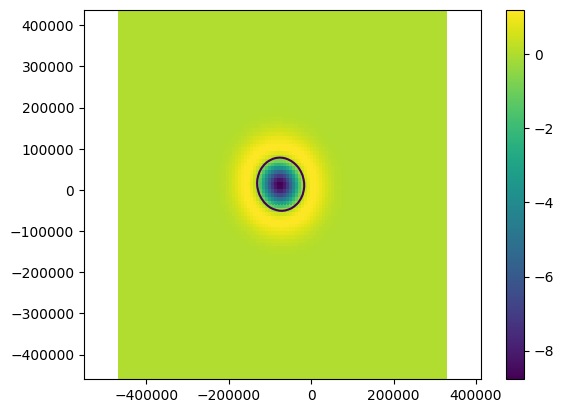

In [14]:
t_idx = 44
k = 32
plt.pcolor(x_ssh, y_ssh, OW[:,:,k,t_idx])
plt.colorbar()
plt.contour(x_ssh, y_ssh, OW[:,:,k,t_idx], levels=[-0.2])
plt.axis('equal')
